<a href="https://colab.research.google.com/github/reesha-rsh/MLb4/blob/main/Homework/Homework_7_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv("/content/drive/MyDrive/MLb4/EDA Titanic/train.csv")
test = pd.read_csv("/content/drive/MyDrive/MLb4/EDA Titanic/test.csv")

Mounted at /content/drive


In [2]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


2. Make a basic EDA, write briefly a few conclusions that, in your opinion, will affect the model / model validation / metrics

I am removing text features that I think will not be usefull for the models. Also One-Hot Encoding for Sex. Most probably the Sex affects the result the most.

In [3]:
useless_features = ['Name','Ticket','Cabin','Embarked']

In [4]:
train_cleaned = train.drop(columns = useless_features)

train_cleaned

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,male,22.0,1,0,7.2500
1,2,1,1,female,38.0,1,0,71.2833
2,3,1,3,female,26.0,0,0,7.9250
3,4,1,1,female,35.0,1,0,53.1000
4,5,0,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000
887,888,1,1,female,19.0,0,0,30.0000
888,889,0,3,female,NaN,1,2,23.4500
889,890,1,1,male,26.0,0,0,30.0000


In [5]:
# generate binary values using get_dummies
train_cleaned = pd.get_dummies(train_cleaned, columns=['Sex'],prefix=["Sex"])
train_cleaned

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,1,0,3,22.0,1,0,7.2500,0,1
1,2,1,1,38.0,1,0,71.2833,1,0
2,3,1,3,26.0,0,0,7.9250,1,0
3,4,1,1,35.0,1,0,53.1000,1,0
4,5,0,3,35.0,0,0,8.0500,0,1
...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,0,1
887,888,1,1,19.0,0,0,30.0000,1,0
888,889,0,3,NaN,1,2,23.4500,1,0
889,890,1,1,26.0,0,0,30.0000,0,1


In [6]:
# Check for NaN values in the DataFrame
nan_mask = train_cleaned.isnull()

# Print the DataFrame with boolean values (True for NaN, False for non-NaN)
print(nan_mask)

# Count the number of NaN values in each column
nan_count_per_column = train_cleaned.isnull().sum()

# Print the number of NaN values per column
print(nan_count_per_column)

     PassengerId  Survived  Pclass    Age  SibSp  Parch   Fare  Sex_female  \
0          False     False   False  False  False  False  False       False   
1          False     False   False  False  False  False  False       False   
2          False     False   False  False  False  False  False       False   
3          False     False   False  False  False  False  False       False   
4          False     False   False  False  False  False  False       False   
..           ...       ...     ...    ...    ...    ...    ...         ...   
886        False     False   False  False  False  False  False       False   
887        False     False   False  False  False  False  False       False   
888        False     False   False   True  False  False  False       False   
889        False     False   False  False  False  False  False       False   
890        False     False   False  False  False  False  False       False   

     Sex_male  
0       False  
1       False  
2       False  

In [7]:
age_median = train_cleaned['Age'].median()
age_median

28.0

In [8]:
train_cleaned['Age'] = train_cleaned['Age'].fillna(age_median)


3. Describe your validation approach and metrics for this dataset.

*   Validation approach: We have a small amount of data so I will use a **K Fold** method
*   Metric: I plan to optimize **precision**, thus minimizing false positives - reducing the prediction that a passenger survived when he actually did not.



4. Train and tune logistic regression (optimise the metric).

In [9]:
titanic_features = train_cleaned[['Pclass',	'Age',	'SibSp',	'Parch',	'Fare',	'Sex_female',	'Sex_male']]
titanic_label = train_cleaned['Survived']

In [18]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, fbeta_score
from sklearn import metrics

# Define the logistic regression model
classifier = LogisticRegression()

params = dict(C=[100, 10, 1, 0.1, 0.01, 0.001, 0.0001])

# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the custom scoring function with the desired beta value
beta = 0.1
custom_scorer = make_scorer(fbeta_score, beta=beta)

# Initialize the GridSearchCV object with the custom scoring function
grid_search = GridSearchCV(classifier, param_grid=params, scoring=custom_scorer, cv=skf)

# Perform grid search with K-fold cross-validation to find the best hyperparameters
grid_search.fit(titanic_features, titanic_label)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the model with the best hyperparameters on the full data
best_model.fit(titanic_features, titanic_label)

# Make predictions on the test set
y_pred = best_model.predict(titanic_features)

# Calculate the F-beta score with the specified beta value
fbeta = fbeta_score(titanic_label, y_pred, beta=beta)

print("Best Hyperparameters:", best_params)
print("F-beta Score (beta={}): {:.4f}".format(beta, fbeta))
print(metrics.classification_report(titanic_label, y_pred))
print(metrics.confusion_matrix(titanic_label, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Hyperparameters: {'C': 0.01}
F-beta Score (beta=0.1): 0.8439
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       549
           1       0.85      0.53      0.65       342

    accuracy                           0.78       891
   macro avg       0.81      0.73      0.75       891
weighted avg       0.80      0.78      0.77       891

[[517  32]
 [162 180]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

--- Beta = 0.1 ---
Best Hyperparameters: {'C': 0.01}
F-beta Score (beta=0.1): 0.8439
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       549
           1       0.85      0.53      0.65       342

    accuracy                           0.78       891
   macro avg       0.81      0.73      0.75       891
weighted avg       0.80      0.78      0.77       891

[[517  32]
 [162 180]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

--- Beta = 0.5 ---
Best Hyperparameters: {'C': 0.1}
F-beta Score (beta=0.5): 0.7432
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       549
           1       0.76      0.68      0.72       342

    accuracy                           0.79       891
   macro avg       0.79      0.77      0.78       891
weighted avg       0.79      0.79      0.79       891

[[477  72]
 [111 231]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

--- Beta = 1 ---
Best Hyperparameters: {'C': 0.1}
F-beta Score (beta=1): 0.7163
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       549
           1       0.76      0.68      0.72       342

    accuracy                           0.79       891
   macro avg       0.79      0.77      0.78       891
weighted avg       0.79      0.79      0.79       891

[[477  72]
 [111 231]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

--- Beta = 2 ---
Best Hyperparameters: {'C': 100}
F-beta Score (beta=2): 0.7168
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       549
           1       0.74      0.71      0.73       342

    accuracy                           0.79       891
   macro avg       0.78      0.78      0.78       891
weighted avg       0.79      0.79      0.79       891

[[465  84]
 [ 99 243]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

--- Beta = 5 ---
Best Hyperparameters: {'C': 100}
F-beta Score (beta=5): 0.7117
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       549
           1       0.74      0.71      0.73       342

    accuracy                           0.79       891
   macro avg       0.78      0.78      0.78       891
weighted avg       0.79      0.79      0.79       891

[[465  84]
 [ 99 243]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

--- Beta = 10 ---
Best Hyperparameters: {'C': 100}
F-beta Score (beta=10): 0.7108
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       549
           1       0.74      0.71      0.73       342

    accuracy                           0.79       891
   macro avg       0.78      0.78      0.78       891
weighted avg       0.79      0.79      0.79       891

[[465  84]
 [ 99 243]]


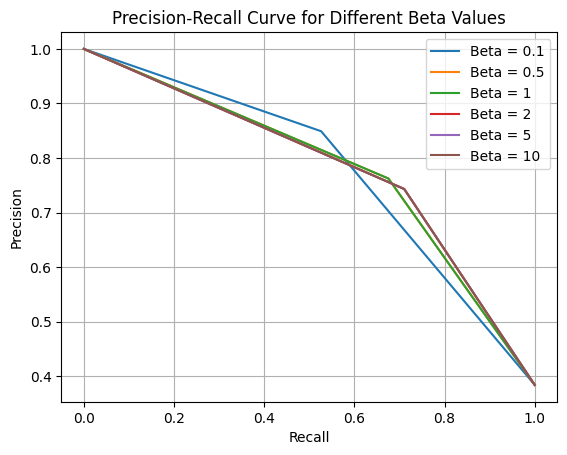

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, fbeta_score, precision_recall_curve
from sklearn import metrics

# Assuming you have titanic_features and titanic_label as the feature and label data

# Define the logistic regression model
classifier = LogisticRegression()

# Define the hyperparameter grid
params = dict(C=[100, 10, 1, 0.1, 0.01, 0.001, 0.0001])

# Initialize the StratifiedKFold object for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the beta values for the F-beta score
beta_values = [0.1, 0.5, 1, 2, 5, 10]

# Perform hyperparameter tuning with GridSearchCV and F-beta scoring
for beta in beta_values:
    # Define the custom scoring function with the current beta value
    custom_scorer = make_scorer(fbeta_score, beta=beta)

    # Initialize the GridSearchCV object with the custom scoring function
    grid_search = GridSearchCV(classifier, param_grid=params, scoring=custom_scorer, cv=skf)

    # Perform grid search with K-fold cross-validation to find the best hyperparameters
    grid_search.fit(titanic_features, titanic_label)

    # Get the best hyperparameters and the corresponding model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Train the model with the best hyperparameters on the full data
    best_model.fit(titanic_features, titanic_label)

    # Make predictions on the test set
    y_pred = best_model.predict(titanic_features)

    # Calculate the F-beta score with the specified beta value
    fbeta = fbeta_score(titanic_label, y_pred, beta=beta)

    # Print the results for the current beta value
    print(f"--- Beta = {beta} ---")
    print("Best Hyperparameters:", best_params)
    print("F-beta Score (beta={}): {:.4f}".format(beta, fbeta))
    print(metrics.classification_report(titanic_label, y_pred))
    print(metrics.confusion_matrix(titanic_label, y_pred))

    # Plot the precision-recall curve for the current beta value
    precision, recall, _ = precision_recall_curve(titanic_label, y_pred)
    plt.plot(recall, precision, label=f'Beta = {beta}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Different Beta Values')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
print(metrics.accuracy_score(titanic_label, y_pred))

0.7822671156004489


In [54]:
print(metrics.classification_report(titanic_label, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84       549
           1       0.85      0.53      0.65       342

    accuracy                           0.78       891
   macro avg       0.81      0.73      0.75       891
weighted avg       0.80      0.78      0.77       891



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Average Accuracy: 0.7901261691042623
Average Train Accuracy: 0.7971374316466269
Average F1 Score: 0.7172313332500366
Average ROC AUC Score: 0.8529599723270387
Average Precision Score: 0.743496374232351


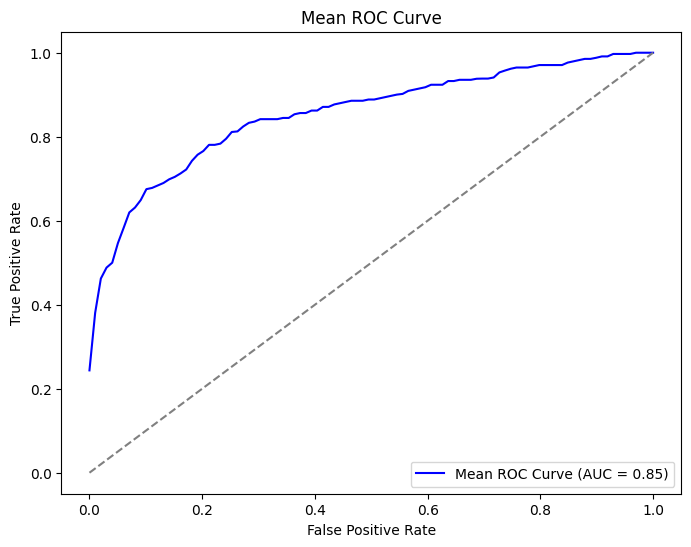

In [46]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, auc, precision_score
import numpy as np

# Define the logistic regression model
classifier = LogisticRegression()

# Number of folds for cross-validation
n_splits = 5

# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store performance metrics for each fold
accuracy_scores = []
train_accuracy_scores = []
f1_scores = []
roc_auc_scores = []
precision_scores = []
mean_fpr = np.linspace(0, 1, 100)
tpr_sum = 0

# Perform stratified K-fold cross-validation
for train_index, test_index in skf.split(titanic_features, titanic_label):
    X_train, X_test = titanic_features.iloc[train_index], titanic_features.iloc[test_index]
    y_train, y_test = titanic_label.iloc[train_index], titanic_label.iloc[test_index]

    # Train the model on the training data for this fold
    model = classifier.fit(X_train, y_train)

    # Make predictions on the validation data for this fold
    predictions = model.predict(X_test)

    # Evaluate the model's performance for this fold
    accuracy = accuracy_score(y_test, predictions)
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision = precision_score(y_test, predictions)

    # Append the performance metrics to the lists
    accuracy_scores.append(accuracy)
    train_accuracy_scores.append(train_accuracy)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    precision_scores.append(precision)

    # Compute ROC curve for this fold
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    tpr_sum += np.interp(mean_fpr, fpr, tpr)

# Compute the average performance metrics across all folds
avg_accuracy = np.mean(accuracy_scores)
avg_train_accuracy = np.mean(train_accuracy_scores)
avg_f1_score = np.mean(f1_scores)
avg_roc_auc_score = np.mean(roc_auc_scores)
avg_precision_score = np.mean(precision_scores)

# Compute the mean ROC curve across all folds
mean_tpr = tpr_sum / n_splits
mean_auc = auc(mean_fpr, mean_tpr)

# Print the average performance metrics
print("Average Accuracy:", avg_accuracy)
print("Average Train Accuracy:", avg_train_accuracy)
print("Average F1 Score:", avg_f1_score)
print("Average ROC AUC Score:", avg_roc_auc_score)
print("Average Precision Score:", avg_precision_score)

# Plot the mean ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC Curve (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [35]:
from sklearn.model_selection import train_test_split



titanic_features_train, titanic_features_test, titanic_label_train, titanic_label_test = \
  train_test_split(X, y, test_size=0.2, random_state=42, stratify = y )

In [28]:
titanic_label_train.value_counts(normalize=1)

0    0.616573
1    0.383427
Name: Survived, dtype: float64

In [29]:
titanic_label_train.value_counts(normalize=1)

0    0.616573
1    0.383427
Name: Survived, dtype: float64

In [36]:
# fit a model to the training data
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

model = classifier.fit(titanic_features_train, titanic_label_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(




5. Do the same with a decision tree.

6. Visualize the decision tree and interpret the model (describe the most important features, whether the splits are logical, etc.)

7. If there is a test dataset, then make predictions on it and compare the result on lb with what you've got on validation (if there is no test dataset, then create it yourself, before training the model, separate 15-20% from the dataset and it will be your test). on the test, you run the model only once to find out the final result.